Now import some commonly used libraries.

In [1]:
import numpy as np

from matplotlib import pyplot as plt

Finally, some functions that will be helpful for building our model and fitting it.

In [2]:
from scipy.stats import distributions
from scipy.optimize import minimize

# Load some data

From [astrostatistics.psu.edu](https://astrostatistics.psu.edu/datasets/censor.html):

> Here we present a censored dataset from stellar astronomy where the authors seek differences in the properties of stars that do and do not host extrasolar planetary systems.  It had already been established that the probability of finding a planet is a steeply rising function of the star's metal content, but it was unclear whether this arises from the metallicity at birth or from later accretion of planetary bodies.  This study focuses on the abundances of the light elements beryllium (Be) and lithium (Li) that are thought to be depleted by internal stellar burning, so that excess Be and Li should be present only in the planet accretion scenario of metal enrichment.
>
>The dataset and figures below are obtained from the following paper:
>
>    Are beryllium abundances anomalous in stars with giant planets? N. C. Santos, G. Israelian, R. J. García López, M. Mayor, R. Rebolo, S. Randich, A. Ecuvillon, and C. Domínguez Cerdeña; Astronomy & Astrophysics, 437, 1086-1096 (2004)
>
>The columns of the dataset are:
>
>    1. Star name
>    1. Sample.  Type=1 indicates planet-hosting stars.  Type=2 is the control sample
>    1. Teff (in degrees Kelvin) stellar surface temperature
>    1. log N(Be), log of the abundance of beryllium scaled to the Sun's abundance (i.e. the Sun has log N(Be)=0.0).
>    1. Measurement error to log N(Be) based on model-fitting of the observed stellar spectrum
>    1. log N(Li), log of the abundance of lithium scaled to the Sun's abundance

In [3]:
!wget --no-check-certificate https://astrostatistics.psu.edu/datasets/censor.dat

--2020-04-03 06:07:01--  https://astrostatistics.psu.edu/datasets/censor.dat
Resolving astrostatistics.psu.edu (astrostatistics.psu.edu)... 168.62.182.234
Connecting to astrostatistics.psu.edu (astrostatistics.psu.edu)|168.62.182.234|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3932 (3.8K)
Saving to: ‘censor.dat’

censor.dat          100%[===================>]   3.84K  --.-KB/s    in 0s      

2020-04-03 06:07:01 (133 MB/s) - ‘censor.dat’ saved [3932/3932]



In [4]:
with open('./censor.dat', 'r') as inp:
    for i in range(5):
        print(inp.readline())

Star     Type  Teff  Ind_Be logN_Be sig_Be  Ind_Li logN_Li

BD-103166  1   5320    1    0.50     NaN     1      NaN

HD_6434    1   5835    1    1.08    0.10     0      0.8

HD_9826    1   6212    1    1.05    0.13     1      2.55

HD_10647   1   6143    1    1.19    0.10     1      2.80



We can use numpy's `np.genfromtxt()` function to read the data.  Though it will take a little hand holding.

In [5]:
np.genfromtxt('censor.dat', names=True)[:5]

array([(nan, 1., 5320., 1., 0.5 ,  nan, 1.,  nan),
       (nan, 1., 5835., 1., 1.08, 0.1 , 0., 0.8 ),
       (nan, 1., 6212., 1., 1.05, 0.13, 1., 2.55),
       (nan, 1., 6143., 1., 1.19, 0.1 , 1., 2.8 ),
       (nan, 1., 5641., 1., 1.31, 0.13, 1., 1.96)],
      dtype=[('Star', '<f8'), ('Type', '<f8'), ('Teff', '<f8'), ('Ind_Be', '<f8'), ('logN_Be', '<f8'), ('sig_Be', '<f8'), ('Ind_Li', '<f8'), ('logN_Li', '<f8')])

That gets us what we would need, though it takes some further care to parse strings properly, etc.

We can also use `pandas`, which works pretty well out of the box.

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('censor.dat', delim_whitespace=True)
df

,Star,Type,Teff,Ind_Be,logN_Be,sig_Be,Ind_Li,logN_Li
0,BD-103166,1,5320,1,0.50,NaN,1,NaN
1,HD_6434,1,5835,1,1.08,0.10,0,0.80
2,HD_9826,1,6212,1,1.05,0.13,1,2.55
3,HD_10647,1,6143,1,1.19,0.10,1,2.80
4,HD_10697,1,5641,1,1.31,0.13,1,1.96
...,...,...,...,...,...,...,...,...
63,HD_85117,2,6167,1,1.11,0.11,1,2.64
64,HD_189567,2,5765,1,1.06,0.10,0,0.82
65,HD_192310,2,5069,0,0.60,NaN,0,0.20
66,HD_211415,2,5890,1,1.12,0.10,1,1.92


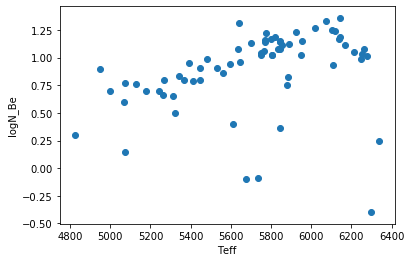

In [8]:
plt.scatter(df.Teff, df.logN_Be)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name);

>The dataset consists of 39 stars known to host planets (plotted as filled circles) and 29 stars in a control sample (open circles).  Due to internal stellar processes, Be abundances are correlated with stellar mass which is traced by stellar surface temperature ("effective temperature" or Teff).  Regression lines of the detections only (top panel) show a slight elevation in Be abundance for planet hosting stars, but this difference evaporates when a Buckley-James regression line is considered that includes the effects of censoring (bottom panel).  

# Construct a model

We're interested in general trends at the moment, so lets use a stupidly simple model: a line.

$$
\hat{y} = mx + b
$$

In [9]:
def build_linear_model(slope, intercept):
    def linear_model(year):
        return year * slope + intercept
    return linear_model

We don't expect global temperatures to exactly follow such a trend, so we need to include a random noise term.  For simplicitly lets assume the random scatter about the line to be normal.  According to this model, we expect actual temperatures to follow:
$$
y \sim \mathrm{N}(\hat{y}, \sigma)
$$

This allows us to construct a likelihood.

In [10]:
def lnlikelihood(x):
    # Unpack the model variables
    slope, intercept, sigma_noise = x
    
    # Build the linear (i.e., "signal") portion of the model
    linear_model = build_linear_model(slope, intercept)
    
    # Subtract the model from the data, leaving just the "noise" if we've done a proper fit
    residuals = df.logN_Be - linear_model(df.Teff)
    
    # Assess how consistent the residuals are with our model for the noise (normal)
    lnlike = np.sum(distributions.norm.logpdf(residuals, loc=0, scale=sigma_noise))
    return lnlike

## Find the best fit

In the future we will sample the posterior distribution.  For now lets just find the maximum likelihood point, which provides us with the best fit parameters.

We will use [Powell's method](https://en.wikipedia.org/wiki/Powell%27s_method) to find the point that maximizes the likelihood, but first we need an initial guess to start from. 

In [11]:
x0 = [.001, 0, 1.]

Lets see how bad our initial guess is...

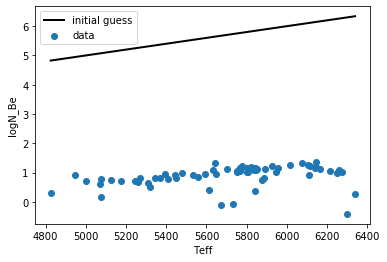

In [12]:
x0_model = build_linear_model(x0[0], x0[1])
teff_grid = np.linspace(min(df.Teff), max(df.Teff))

plt.scatter(df.Teff, df.logN_Be, label='data')
plt.plot(teff_grid, x0_model(teff_grid), color='k', lw=2, label='initial guess')
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name);
plt.legend();

Comically bad...

Now lets run the maximization algorithm.

In [13]:
sol = minimize(lambda x: -lnlikelihood(x), x0, method='powell')
best_fit_params = sol.x

..and take a look at our best fit.

Best fit slope of 0.000302485.


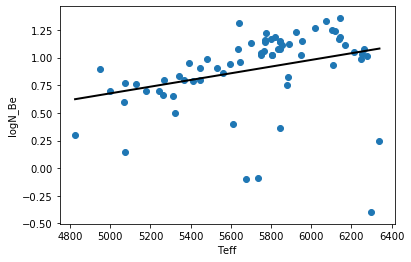

In [14]:
best_fit_model = build_linear_model(best_fit_params[0], best_fit_params[1])

plt.scatter(df.Teff, df.logN_Be, label='data')
plt.plot(teff_grid, best_fit_model(teff_grid), color='k', lw=2)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name);

print("Best fit slope of {:g}.".format(best_fit_params[0]))

# Check the fit

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


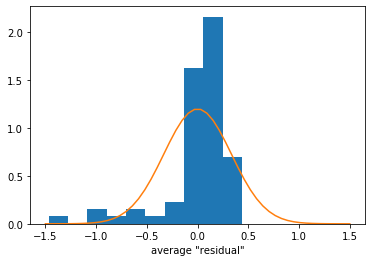

In [15]:
xs = np.linspace(-1.5, 1.5, 50)
residual_temps = df.logN_Be - best_fit_model(df.Teff)

plt.hist(residual_temps, bins=10, normed=True);
plt.plot(xs, distributions.norm.pdf(xs, scale=best_fit_params[2]))
plt.xlabel('average "residual"');

Text(0, 0.5, 'average "residual"')

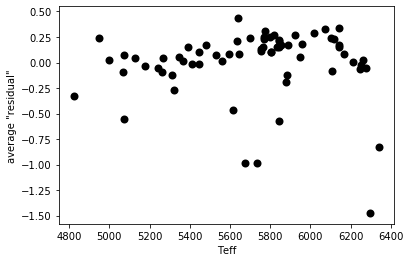

In [16]:
xs = np.linspace(1880, 2017, 50)

plt.scatter(df.Teff, residual_temps, color='k', lw=2)

plt.xlabel(df.Teff.name)
plt.ylabel('average "residual"')